#🎯Broadcast Insight: Tactical Intelligence Using Meta's SAM
*Frame-by-Frame Player and Ball Segmentation for Tactical Pattern Recognition*

##✅ Step 1: Introduction

**Goal**: Understand how segmentation enables tactical analysis in sports.

###Topics:
- Difference between detection vs segmentation
- Tactical uses: tracking movement, possession, spacing
- Introduction to Meta’s SAM and frame-wise segmentation

-- -- --

##✅ Step 2: Install and Set Up SAM

**Goal**: Prepare the Segment Anything Model (SAM) for inference.

###Topics:
- Check if your collab runtime has GPU. Go to Runtime -> Change runtime type

- Installing dependencies

```!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib
```
- Download Segment Anything library from: `https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
- Then upload Segment Anything library to you session storage.
- Copy the file path for Segment Anything
Or
- In a code cell execute following command: `!wget -P /content/sam_vit_b_01ec64.pth`

- Loading SAM checkpoint

- Initializing the predictor



In [1]:
!pip install opencv-python matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install pillow ipyevents ipycanvas

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6o7yj_cg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6o7yj_cg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=16e7d121547927e3f42faec807ce5ee1fe912d41c7c0228b96b92901115b783d
  Stored in directory: /tmp/pip-ephem-wheel-cache-e_o5sb4n/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.6 MB/s eta 0:00:00


In [2]:
!wget -O sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-06-29 13:47:03--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  29.4MB/s    in 6.9s    

2025-06-29 13:47:10 (52.1 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [3]:
from segment_anything import sam_model_registry, SamPredictor
import torch
import cv2

sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda")
predictor = SamPredictor(sam)

## ✅ Step 3: Extract Frames from a Sports Video

**Goal**: Convert a video into discrete frames for SAM input.

###Topics:
- Using OpenCV to read video
- Sampling every Nth frame for performance



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
from google.colab import files

In [5]:
cap = cv2.VideoCapture("table-tennis_cut.mp4") # change this to the video you have
frames = []
frame_interval = 5

# Check if the video file was opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_idx % frame_interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()

##✅ Step 4: Run SAM on Each Frame

**Goal**: Segment players or ball across all extracted frames. You have to select the point to give to SAM that will segment the object

###Topics:
- Setting image for SAM
- Using click-point prompts or bounding boxes

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:

# 2) Show the first frame on a true-pixel canvas and capture one click
import numpy as np
from ipycanvas import Canvas
from IPython.display import display, clear_output

# assume `frames[0]` is H×W×3 uint8
h, w = frames[0].shape[:2]
canvas = Canvas(width=w, height=h)

# draw the image data directly
canvas.put_image_data(frames[0], 0, 0)

coords = {}
def handle_click(x, y):
    coords['x'], coords['y'] = x, y
    clear_output()
    print(f"✅  Click recorded at x={x}, y={y}")

canvas.on_mouse_down(handle_click)
display(canvas)


✅  Click recorded at x=297, y=197


Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

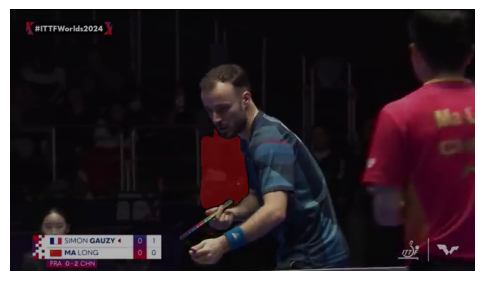

KeyboardInterrupt: 

In [8]:
# Example: Use the same center point on each frame (can be dynamic)
import numpy as np
import cv2

from IPython.display import clear_output
import matplotlib.pyplot as plt
segmented_masks = []
input_point = np.array([[300, 191]])  # Example center point. Change this if you want to segment another point.
input_label = np.array([1])  # Positive label

for frame in frames:
    predictor.set_image(frame)
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False
    )
    mask = masks[0]
    segmented_masks.append(masks)
    # 2. Create a color overlay (red) where mask==True
    color_mask = np.zeros_like(frame, dtype=np.uint8)
    color_mask[..., 0] = (mask * 255).astype(np.uint8)   # red channel
    # 3. Blend overlay with original frame
    overlayed = cv2.addWeighted(frame, 0.7, color_mask, 0.3, 0)

    # 4. Display inline
    clear_output(wait=True)          # clear previous frame
    plt.figure(figsize=(6,6))
    # Colab frames are usually RGB; if BGR, convert with cv2.COLOR_BGR2RGB
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()

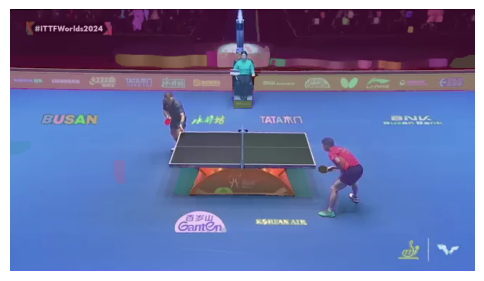

KeyboardInterrupt: 

In [9]:
#Segment the everything in the frame
from segment_anything import SamAutomaticMaskGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

# 1. Create the mask generator (you can tweak these parameters)
mask_generator = SamAutomaticMaskGenerator(
    predictor.model,
    points_per_batch=64,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    box_nms_thresh=0.3,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

for frame in frames[:5]:
    all_mask_dicts = mask_generator.generate(frame)
    overlay = frame.copy()

    for m in all_mask_dicts:
        mask = m["segmentation"]  # H×W boolean
        color = [random.randint(0,255) for _ in range(3)]

        # 1) Make a full image filled with that color
        color_img = np.zeros_like(frame, dtype=np.uint8)
        color_img[..., 0] = color[0]
        color_img[..., 1] = color[1]
        color_img[..., 2] = color[2]

        # 2) Blend only in the masked region
        blended = cv2.addWeighted(overlay, 0.7, color_img, 0.3, 0)
        overlay[mask] = blended[mask]   # copy the blended pixels back

    clear_output(wait=True)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

##✅ Step 5: Extract Object Centroids

**Goal**: Convert masks to positions for tracking movement.

###Topics:
- Compute centroid of segmented player/ball
- Track X, Y coordinates per frame

In [ ]:
centroids = []

for mask in segmented_masks:
    coords = np.column_stack(np.where(mask == 1))
    if len(coords) > 0:
        centroid = coords.mean(axis=0)  # [y, x]
        centroids.append(centroid)

##✅ Step 6: Visualize Player or Ball Trails

**Goal**: Draw heatmaps or path trails from tracked positions.

###Topics:
- Scatter plot of centroids
- Heatmap of motion patterns

In [ ]:
import matplotlib.pyplot as plt

centroids = np.array(centroids)
plt.figure(figsize=(10, 6))
plt.scatter(centroids[:,1], centroids[:,0], c=range(len(centroids)), cmap="viridis")
plt.gca().invert_yaxis()
plt.title("Movement Trail (Frame-by-Frame)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.colorbar(label="Frame #")
plt.show()

##✅ Step 7: (Optional) Tactical Zone or Formation Analysis

**Goal**: Analyze spacing or team shape using clusters or hulls.

###Topics:
- Cluster players per frame
- Use scipy.spatial.ConvexHull to estimate formation shape

In [ ]:
from scipy.spatial import ConvexHull
hull = ConvexHull(centroids)

plt.plot(centroids[:,1], centroids[:,0], 'o')
for simplex in hull.simplices:
    plt.plot(centroids[simplex,1], centroids[simplex,0], 'k-')

##✅ Step 8: Hackathon Build Ideas
- Create animated overlays of ball possession or player heatmaps
- Compare formations (e.g., 4-3-3 vs 5-4-1)
- Segment every frame and build a highlight generator based on movement bursts
- Combine SAM + object detector to auto-focus on ball → segment → track

-- -- --

##✅ Optional Extensions:
- Use bounding boxes from YOLOv8 → refine with SAM
- Use segment masks to crop player images and analyze per-frame motion
- Use OpenCV optical flow to generate prompt points for SAM dynamically